# 1. Libraries

In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib
# !pip install python --upgrade
# !pip install keras tensorflow --upgrade

In [2]:
# Importing necessary libraries
import os
import zipfile
import shutil
import numpy as np
import cv2                # For computer vision tasks
import imghdr             # For determining image file types
import tensorflow as tf   # TensorFlow for deep learning

# Importing components for building convolutional neural networks
from keras.models import Sequential,load_model # Sequential model for stacking layers
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dropout,
    Dense,
    Flatten
)

from keras import layers, models, optimizers  # Components for neural networks


# Importing visualization and evaluation libraries
import plotly                           # For interactive plots
import plotly.graph_objects as go       # Module for graph objects in Plotly
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)                                     # Metrics for evaluation

# Importing plotting library for static plots
from matplotlib import pyplot as plt

# Importing utility functions
from sklearn.utils.class_weight import compute_class_weight  # Utility for computing class weights
from keras.callbacks import EarlyStopping                    # Callback for early stopping in model training

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from keras.applications import EfficientNetB0
from keras.applications import VGG16
from keras.applications import ResNet50


# Functions

## Plot Image

In [27]:
def create_class_mapping(directory):
    """
    Create a mapping from class folder names to unique identifiers.

    Parameters:
    - directory (str): Path to the directory containing class subfolders.

    Returns:
    - dict: Mapping from class folder names to unique identifiers.
    """
    class_folders = sorted(os.listdir(directory))
    class_mapping = {folder: i for i, folder in enumerate(class_folders)}
    return class_mapping

def plot_images(tensorflow_dataset, class_mapping, num_batches=4):
    """
    Plot images from a TensorFlow dataset using Matplotlib.

    Parameters:
    - tensorflow_dataset (tf.data.Dataset): TensorFlow dataset containing images and labels.
    - class_mapping (dict): Mapping from class folder names to unique identifiers.
    - num_batches (int): Number of batches to display.
    """
    # Create subplots with the specified number of columns
    num_columns = min(num_batches, 4)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5))

    # Loop through the specified number of batches
    for batch_idx, (images, labels) in enumerate(tensorflow_dataset.take(num_batches)):
        # batch size is 32, choose the first image
        img_array = images[0].numpy().astype(np.uint8)  # Convert to uint8

        # Get class index and map it to class name
        class_index = tf.argmax(labels[0]).numpy()
        class_name = next((name for name, index in class_mapping.items() if index == class_index), f"Class {class_index}")

        # Display the image with class name
        axes[batch_idx].imshow(img_array)
        axes[batch_idx].set_title(class_name)
        axes[batch_idx].axis('off')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

NameError: ignored

## create_image_dataset

In [4]:
def create_image_dataset(directory, batch_size=32, image_size=(224, 224), shuffle=True, seed=42):
    """
    Create a TensorFlow image dataset from a given directory.

    Parameters:
    - directory (str): Path to the directory.
    - batch_size (int): Batch size for the dataset.
    - image_size (tuple): Size of the images (height, width).
    - shuffle (bool): Whether to shuffle the dataset.
    - seed (int): Seed for shuffling.

    Returns:
    - tf.data.Dataset: TensorFlow image dataset.
    """
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='categorical',
        batch_size=batch_size,
        image_size=image_size,
        shuffle=shuffle,
        seed=seed,
        validation_split=None,
        subset=None
    )

In [5]:
!mkdir /content/logs  # Creates a directory for storing logs

logdir = '/content/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
tensorboard_port = 6006

## Plot loss graph

In [6]:
def plot_loss(history):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss']) + 1)),
                             y=history.history['loss'],
                             mode='lines',
                             name='Training Loss',
                             line=dict(color='teal')))

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss']) + 1)),
                             y=history.history['val_loss'],
                             mode='lines',
                             name='Validation Loss',
                             line=dict(color='orange')))

    fig.update_layout(title='Loss',
                      xaxis=dict(title='Epochs'),
                      yaxis=dict(title='Loss'),
                      legend=dict(x=0, y=1.0),
                      showlegend=True,
                      grid=dict(rows=1, columns=1))

    fig.show()


## Plot accuracy graph

In [7]:
def plot_accuracy(history):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy']) + 1)),
                             y=history.history['accuracy'],
                             mode='lines',
                             name='Training Accuracy',
                             line=dict(color='teal')))

    fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy']) + 1)),
                             y=history.history['val_accuracy'],
                             mode='lines',
                             name='Validation Accuracy',
                             line=dict(color='orange')))

    fig.update_layout(title='Accuracy',
                      xaxis=dict(title='Epochs'),
                      yaxis=dict(title='Accuracy'),
                      legend=dict(x=0, y=1.0),
                      showlegend=True,
                      grid=dict(rows=1, columns=1))  # Corrected the grid argument

    fig.show()


## Evaluation of model


In [8]:
def get_class_names(data_dir):
    return sorted(os.listdir(data_dir))

def evaluate_test(model, modelName, test, test_dir):
    print(f"Model: {modelName} / Test: {test_dir}")
    print()

    # Get class names from subfolder names
    class_names = get_class_names(test_dir)

    # Initialize lists to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Loop through the test data to get true and predicted labels
    for batch, labels in test:
        predicted_data = model.predict(batch)
        yhat_classes = np.argmax(predicted_data, axis=1)

        true_labels.extend(np.argmax(labels, axis=1))
        predicted_labels.extend(yhat_classes)

    # Convert the lists to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate precision, recall, and accuracy
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Print precision, recall, and accuracy
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate and print confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    fig = go.Figure(data=[go.Heatmap(z=conf_matrix, x=class_names, y=class_names)])
    fig.update_layout(
        title=f"Confusion Matrix {modelName} applied on {test_dir}",
        xaxis_title="Predicted",
        yaxis_title="True",
        autosize=False,
        width=800,
        height=800
    )
    fig.show()

    # Print classification report with precision, recall, f1-score, and support
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print()
    print(f"Classification Report for {modelName} applied on {test_dir}:")
    print(class_report)

    # Print summary
    print()
    loss, accuracy = model.evaluate(test)
    print(f"Test Loss for {modelName} applied on {test_dir}: {loss:.4f}")
    print(f"Test Accuracy for {modelName} applied on {test_dir}: {accuracy * 100:.2f}%")
    print("-----------------------------------------------------------------------")
    print()

# GPU Check for Colab

In [9]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **COLAB kaggle data file SETUP**

## Downloading Kaggle.json file from github

In [11]:
import requests

# URL of the Kaggle file on GitHub
github_url = "https://raw.githubusercontent.com/dynci22/Thesis/main/kaggle.json"

#HTTP GET request to download the file
response = requests.get(github_url)

#if the request was successful (status code 200)
if response.status_code == 200:

    # Save the content to a json file
    with open("kaggle.json", "wb") as file:
        file.write(response.content)
else:
    print("Failed to download the file.")


## Downloading dataset and unzipping the file

In [12]:
def setup_kaggle_dataset(api_credentials_path, dataset_name):
    # Set up Kaggle API credentials
    if os.path.exists(api_credentials_path):
        kaggle_directory = os.path.expanduser("~/.kaggle")
        os.makedirs(kaggle_directory, exist_ok=True)
        kaggle_config_path = os.path.join(kaggle_directory, "kaggle.json")
        shutil.copy(api_credentials_path, kaggle_config_path)
        os.chmod(kaggle_config_path, 0o600)

        # Download dataset
        download_command = f"kaggle datasets download -d {dataset_name}"
        os.system(download_command)

        # Unzip dataset and remove ZIP files
        zip_files = [file for file in os.listdir() if file.endswith(".zip")]
        for zip_file in zip_files:
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall()
            os.remove(zip_file)

        print("Dataset download and setup completed.")
    else:
        print("Kaggle API credentials (kaggle.json) not found.")

# Specify Kaggle API credentials path and dataset name
kaggle_credentials_path = "/content/kaggle.json"
desired_dataset_name = "gpiosenka/butterfly-images40-species"

# Call the function to set up Kaggle dataset
setup_kaggle_dataset(kaggle_credentials_path, desired_dataset_name)


Dataset download and setup completed.


In [13]:
base_dir = '/content'
dir_names = ['train', 'test', 'valid']
dir_list = [os.path.join(base_dir, dir_name) for dir_name in dir_names]

# Image preprocessing

## Removing Dodgy Images

In [14]:
image_extensions = ['jpeg','jpg', 'bmp', 'png']

In [15]:
def filter_images(dir_list, image_exts):
    for directory in dir_list:
        for image_class in os.listdir(directory):
            for image in os.listdir(os.path.join(directory, image_class)):
                image_path = os.path.join(directory, image_class, image)
                try:
                    img = cv2.imread(image_path)
                    image_type = imghdr.what(image_path)

                    if image_type not in image_exts:
                        print(f'Image not in extension list: {image_path}')
                        os.remove(image_path)

                except Exception as e:
                    print(f'Issue with image: {image_path}')

filter_images(dir_list, image_extensions)

## Count Images

In [16]:
def count_images_in_dir(directory, image_extensions):
    """
    Count the number of images in a given directory with specified image extensions.

    Parameters:
    - directory (str): Path to the directory.
    - image_extensions (list): List of allowed image file extensions.

    Returns:
    - int: Count of images in the directory.
    """
    count = 0
    for root, dirs, files in os.walk(directory):
        count += sum(1 for filename in files if any(filename.lower().endswith(ext) for ext in image_extensions))
    return count

def generate_directory_stats(dir_list, image_extensions):
    """
    Generate statistics for each directory in the list.

    Parameters:
    - dir_list (list): List of directory paths.
    - image_extensions (list): List of allowed image file extensions.

    Returns:
    - tuple: Total folder count, total image count, folder names, subfolder counts, image counts.
    """
    folder_names = []
    subfolder_counts = []
    image_counts = []

    total_folder_count = 0
    total_image_count = 0

    for dir_path in dir_list:
        subfolder_count = len(next(os.walk(dir_path))[1])
        current_image_count = count_images_in_dir(dir_path, image_extensions)

        folder_names.append(dir_path)
        subfolder_counts.append(subfolder_count)
        image_counts.append(current_image_count)

        total_folder_count += 1 + subfolder_count
        total_image_count += current_image_count

    return total_folder_count, total_image_count, folder_names, subfolder_counts, image_counts

def display_directory_stats(dir_list, image_extensions):
    """
    Display directory statistics using Plotly.

    Parameters:
    - dir_list (list): List of directory paths.
    - image_extensions (list): List of allowed image file extensions.

    Returns:
    - tuple: Total folder count, total image count.
    """
    total_folder_count, total_image_count, folder_names, subfolder_counts, image_counts = generate_directory_stats(dir_list, image_extensions)

    table_data = [folder_names, subfolder_counts, image_counts]

    header = ["Folder Name", "Subfolders", "Images"]
    table = go.Figure(data=[go.Table(header=dict(values=header),
                                     cells=dict(values=table_data))
                           ])

    table.show()

    return total_folder_count, total_image_count


# Exploratory Data Analysis

## Load Data

In [17]:
total_folders, total_images = display_directory_stats(dir_list, image_extensions)
print(f"Total folders: {total_folders}, Total images: {total_images}")

Total folders: 303, Total images: 13594


In [18]:
data_train = create_image_dataset(dir_list[0])
data_test = create_image_dataset(dir_list[1])
data_valid = create_image_dataset(dir_list[2])


Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


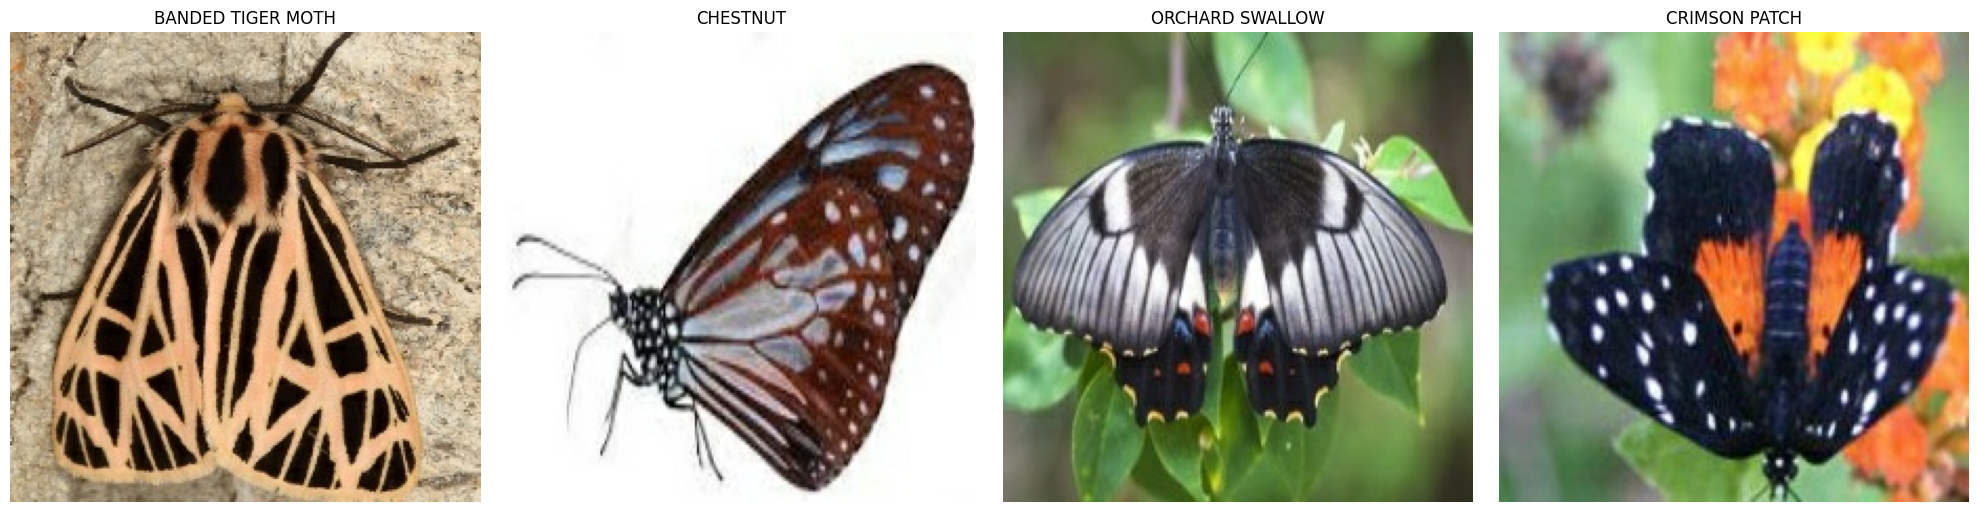

In [29]:
train_directory = "/content/train"
class_mapping = create_class_mapping(train_directory)
plot_images(data_train,class_mapping)

## Visualization of class balance

In [20]:
# Initialized a dictionary to store class names and their respective image counts
class_image_counts = {}
base_dir = "/content/train"
# Iterated through the subdirectories (classes) in the base directory
for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)

    # Checked if it was a directory
    if os.path.isdir(class_dir):
        # Listed all files in the directory with a specific image file extension (e.g., .jpg, .jpeg, .png, .gif)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

        # Counted the number of image files in the directory
        image_count = len(image_files)

        # Stored the class name and image count in the dictionary
        class_image_counts[class_name] = image_count

# Created a DataFrame from the dictionary
df = pd.DataFrame(list(class_image_counts.items()), columns=['Class Name', 'Image Count'])

# Added a serial number column
df['Serial No'] = range(1, len(df) + 1)

# Sorted the DataFrame by Serial No in ascending order
df = df.sort_values(by='Serial No', ascending=True)

# Calculated the mean of the "Image Count" column
mean_image_count = df['Image Count'].mean()

# Created a table using Plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=['Sr. No', 'Class Name', 'Image Count'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df['Serial No'], df['Class Name'], df['Image Count']],
               fill_color='lavender',
               align=['center', 'left', 'center']),  # Adjusted alignment
    columnwidth=[0.10, 0.15, 0.10]  # Adjusted column widths
)
])

# Customized the table layout
fig.update_layout(
    title='Image Counts by Class',
    width = 700, height = 600
)

# Showed the table
fig.show()

# Created a bar chart using Plotly Express
fig = px.bar(df, x='Class Name', y='Image Count', title='Image Counts by Butterfly Species',
             color='Image Count',  # Color grading based on image count
             color_continuous_scale='viridis')  # Using a color scale for better visualization

# Added a mean line to the bar chart
fig.add_hline(y=mean_image_count, line_dash="dot", line_color="red", annotation_text=f'Mean: {mean_image_count:.2f}', annotation_position="top right")

# Customized the chart layout
fig.update_layout(xaxis_title='Butterfly Species', yaxis_title='Image Count')
fig.update_xaxes(categoryorder='total descending')  # Sorted bars by total image count in descending order

# Showed the chart
fig.show()


# 6. Build Deep Learning Model

## My CNN Model

In [ ]:
# Creating a Sequential model for a Convolutional Neural Network (CNN) for image classification.

# The model consists of multiple convolutional layers, each followed by batch normalization,
# max pooling, and dropout for feature extraction and regularization.

# Convolutional layers:
# - The first convolutional layer extracts basic features from the input image.
# - Subsequent convolutional layers capture increasingly complex patterns.

# Batch Normalization:
# - Normalizes the activations of the layers, stabilizing and accelerating training.

# Max Pooling:
# - Reduces spatial dimensions, downsampling feature maps and retaining important information.

# Dropout:
# - Regularization technique that randomly drops a fraction of input units during training,
#   preventing overfitting and promoting more robust feature learning.

model = models.Sequential()

# Convolutional layers with batch normalization and dropout
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  # Extracts basic features
model.add(layers.BatchNormalization())  # Stabilizes and accelerates training
model.add(layers.MaxPooling2D((2, 2)))  # Downsampling, retains important information
model.add(layers.Dropout(0.25))  # Prevents overfitting

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Additional Convolutional layers with batch normalization and dropout
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())  # Converts 3D feature maps to a 1D vector

# Dense layers with dropout
model.add(layers.Dense(512, activation='relu'))  # Fully connected layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))  # Regularization to prevent overfitting

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='softmax'))  # 100 classes

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.0001
adam_optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_7 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_8 (Bat  (None, 109, 109, 64)     

## Train

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping, tensorboard_callback])

# 8. Plot Performance

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

# 9. Evaluate

In [ ]:
# Evaluate on the 'test' dataset
evaluate_test(model, "my_CNN_Model", data_test, dir_list[1])


Model: my_CNN_Model / Test: /content/test

1/1 [==============================] - 0s 184ms/step
Precision: 86.09%
Recall: 84.40%
Accuracy: 84.40%



Classification Report for my_CNN_Model applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       0.80      0.80      0.80         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       0.50      0.40      0.44         5
                    AN 88       1.00      0.80      0.89         5
                  APPOLLO       1.00      0.60      0.75         5
     ARCIGERA FLOWER MOTH       0.80      0.80      0.80         5
                    ATALA       0.67      0.80      0.73         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       0.83      1.00      0.91         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      1.00      1.00         5
            BECKERS WHITE       0.50      0.20      0.29         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00      

# EfficientNetB0


In [21]:
# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model.trainable = False

custom_model = models.Sequential()

# Add the pre-trained model
custom_model.add(base_model)


custom_model.add(layers.Flatten())
custom_model.add(layers.Dense(256, activation='relu'))
custom_model.add(layers.BatchNormalization())
custom_model.add(layers.Dropout(0.5))
custom_model.add(layers.Dense(100, activation='softmax'))

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
adam_optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

custom_model.compile(optimizer=adam_optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Print model summary
custom_model.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 256)               16056576  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [22]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping
history = custom_model.fit(data_train, epochs=5, validation_data=data_valid, callbacks=[early_stopping, tensorboard_callback])
custom_model.save("custom_model_EfficientNetB0.keras")

Epoch 1/5
394/394 [==============================] - 60s 111ms/step - loss: 1.4846 - accuracy: 0.6621 - val_loss: 0.3860 - val_accuracy: 0.9080
Epoch 2/5
394/394 [==============================] - 36s 91ms/step - loss: 0.3058 - accuracy: 0.9258 - val_loss: 0.2618 - val_accuracy: 0.9320
Epoch 3/5
394/394 [==============================] - 35s 89ms/step - loss: 0.1495 - accuracy: 0.9642 - val_loss: 0.2519 - val_accuracy: 0.9360
Epoch 4/5
394/394 [==============================] - 36s 92ms/step - loss: 0.0930 - accuracy: 0.9782 - val_loss: 0.2431 - val_accuracy: 0.9460
Epoch 5/5
394/394 [==============================] - 36s 90ms/step - loss: 0.0713 - accuracy: 0.9836 - val_loss: 0.2561 - val_accuracy: 0.9380


In [23]:
evaluate_test(custom_model, "EfficientNetB0", data_test, dir_list[1])

Model: EfficientNetB0 / Test: /content/test

1/1 [==============================] - 2s 2s/step
Precision: 95.03%
Recall: 94.00%
Accuracy: 94.00%



Classification Report for EfficientNetB0 applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       0.80      0.80      0.80         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      1.00      1.00         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       1.00      1.00      1.00         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      1.00      1.00         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       0.83      1.00      0.91         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       1.00      0.80      0.89         5
            BECKERS WHITE       1.00      0.80      0.89         5
  BIRD CHERRY ERMINE MOTH       1.00      0.80      0.89    

In [24]:
plot_loss(history)
plot_accuracy(history)

# VGG-16

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable = False

vgg_custom_model = models.Sequential()
vgg_custom_model.add(vgg_model)
vgg_custom_model.add(layers.Flatten())
vgg_custom_model.add(layers.Dense(256, activation='relu'))
vgg_custom_model.add(layers.BatchNormalization())
vgg_custom_model.add(layers.Dropout(0.5))
vgg_custom_model.add(layers.Dense(100, activation='softmax'))

vgg_custom_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

vgg_custom_model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_15 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 100)               

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = vgg_custom_model.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping, tensorboard_callback])


Epoch 1/50
394/394 [==============================] - 78s 180ms/step - loss: 1.6617 - accuracy: 0.6303 - val_loss: 0.4361 - val_accuracy: 0.8940
Epoch 2/50
394/394 [==============================] - 64s 161ms/step - loss: 0.2931 - accuracy: 0.9424 - val_loss: 0.3591 - val_accuracy: 0.9140
Epoch 3/50
394/394 [==============================] - 63s 160ms/step - loss: 0.1041 - accuracy: 0.9840 - val_loss: 0.3063 - val_accuracy: 0.9140
Epoch 4/50
394/394 [==============================] - 65s 163ms/step - loss: 0.0600 - accuracy: 0.9898 - val_loss: 0.3424 - val_accuracy: 0.9120
Epoch 5/50
394/394 [==============================] - 63s 160ms/step - loss: 0.0481 - accuracy: 0.9920 - val_loss: 0.3242 - val_accuracy: 0.9140
Epoch 6/50
394/394 [==============================] - 64s 161ms/step - loss: 0.0381 - accuracy: 0.9940 - val_loss: 0.3497 - val_accuracy: 0.9160


In [ ]:
evaluate_test(vgg_custom_model, "vgg_custom_model", data_test, dir_list[1])

Model: vgg_custom_model / Test: /content/test

1/1 [==============================] - 0s 281ms/step
Precision: 95.34%
Recall: 94.00%
Accuracy: 94.00%



Classification Report for vgg_custom_model applied on /content/test:
                           precision    recall  f1-score   support

                   ADONIS       1.00      0.80      0.89         5
AFRICAN GIANT SWALLOWTAIL       1.00      1.00      1.00         5
           AMERICAN SNOOT       1.00      0.80      0.89         5
                    AN 88       1.00      1.00      1.00         5
                  APPOLLO       0.83      1.00      0.91         5
     ARCIGERA FLOWER MOTH       1.00      1.00      1.00         5
                    ATALA       1.00      0.80      0.89         5
               ATLAS MOTH       1.00      1.00      1.00         5
 BANDED ORANGE HELICONIAN       1.00      1.00      1.00         5
           BANDED PEACOCK       1.00      1.00      1.00         5
        BANDED TIGER MOTH       0.83      1.00      0.91         5
            BECKERS WHITE       1.00      1.00      1.00         5
  BIRD CHERRY ERMINE MOTH       1.00      1.00      1.00  

In [ ]:
plot_loss(history)
plot_accuracy(history)

# ResNet50

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    layer.trainable = False

resnet_custom_model = models.Sequential()
resnet_custom_model.add(resnet_model)
resnet_custom_model.add(layers.Flatten())
resnet_custom_model.add(layers.Dense(256, activation='relu'))
resnet_custom_model.add(layers.BatchNormalization())
resnet_custom_model.add(layers.Dropout(0.5))
resnet_custom_model.add(layers.Dense(100, activation='softmax'))

resnet_custom_model.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

resnet_custom_model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               25

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = resnet_custom_model.fit(data_train, epochs=50, validation_data=data_valid, callbacks=[early_stopping, tensorboard_callback])


Epoch 1/50
  5/394 [..............................] - ETA: 43:43 - loss: 5.0544 - accuracy: 0.1063

KeyboardInterrupt: ignored

In [ ]:
evaluate_test(resnet_custom_model, "ResNet50", data_test, dir_list[1])

In [ ]:
plot_loss(history)
plot_accuracy(history)

# Comparision of model

| Model                  | Test Loss | Test Accuracy |
|------------------------|-----------|---------------|
| EfficientNetB0         | 0.2085    | 95.20%        |
| ResNet50               | 0.2555    | 93.40%        |
| VGG Custom Model       | 0.3015    | 92.00%        |
| My_Model_cnn           | 0.9677    | 74.20%        |


# TensorBoard

In [ ]:
!tensorboard dev upload --logdir "/content/logs" --name "CNN Model for Butterfly Classification" --description " Butterfly classification using deep learning" --one_shot

In [ ]:
!pip install streamlit -q
!streamlit run app.py & npx localtunnel --port 8501


[..................] / rollbackFailedOptional: verb npm-session 2f0dbbe9a3647b2


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.195.175:8501

npx: installed 22 in 2.249s
your url is: https://soft-corners-stand.loca.lt
